In [1]:
!pip install emoji==1.7.0 sentence_transformers gensim

Read data

In [27]:
import pandas as pd
import numpy as np

# File path
file_path = '/content/drive/MyDrive/Colab Notebooks/Twitter_Jan_Mar.csv'

# Function to determine which rows to skip
def skip_rows(row_idx):
    if row_idx == 0:
        return False
    return np.random.rand() > 0.20  # Skip rows with an 80% chance

# Try to read the CSV file with skiprows
try:
    df = pd.read_csv(file_path, skiprows=lambda x: skip_rows(x), on_bad_lines='skip')
except pd.errors.ParserError as e:
    print(f"Encountered a parsing error: {e}")
    print("Attempting to load the data without problematic rows using on_bad_lines='skip'")
    df = pd.read_csv(file_path, skiprows=lambda x: skip_rows(x), on_bad_lines='skip')

print(df.head())

                        date                   id  \
0  2023-03-29 22:58:18+00:00  1641213218520481805   
1  2023-03-29 22:57:52+00:00  1641213110915571715   
2  2023-03-29 22:57:20+00:00  1641212975012016128   
3  2023-03-29 22:53:43+00:00  1641212064705449985   
4  2023-03-29 22:50:11+00:00  1641211175185596419   

                                             content         username  \
0           @MecoleHardman4 Chat GPT says it’s 15. 😂     AmyLouWho321   
1  AI muses: "In the court of life, we must all f...   ChatGPT_Thinks   
2  @nytimes No! Chat Gpt has been putting togethe...       cordydbarb   
3  @techAU @elonmusk @TheChiefNerd Walt Disney tr...  SpiderMonkeyXYZ   
4  It's taken me 40+ years to conclude that job d...             LouA   

   like_count  retweet_count  
0         0.0            0.0  
1         0.0            0.0  
2         0.0            0.0  
3         0.0            0.0  
4         1.0            0.0  


Pre Processing

In [28]:
from nltk.corpus import stopwords
import nltk
import gensim
import gensim.downloader as api

# Load the GloVe model
glove_model = api.load("glove-wiki-gigaword-300")

# Function to get similar words using the GloVe model
def get_similar_words(lst_words, top, nlp):
    lst_out = set(lst_words)
    for word in lst_words:
        try:
            similar_words = nlp.most_similar(word, topn=top)
            lst_out.update([tup[0] for tup in similar_words])
        except KeyError:  # Word not in vocabulary
            continue
    return list(lst_out)


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
import emoji
import re



def utils_clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to string in case it's not
    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove emojis
    text = emoji.get_emoji_regexp().sub(u'', text)
    # Remove hashtags and mentions
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove any non-alphanumeric characters (except space)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower().strip()
    return text

# Define the text preprocessing function
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):

    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Stemming (if chosen)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatization (if chosen)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text


In [30]:
df['cleaned_text'] = df['content'].astype(str).apply(utils_clean_text)

# Load stopwords
stop_words = set(stopwords.words('english'))

# Extend stopwords with terms related to ChatGPT and AI
core_terms = ['ai', 'gpt', 'openai', 'chatgpt', 'chatbot']
extended_stop_words = get_similar_words(core_terms, top=15, nlp=glove_model)
stop_words.update(extended_stop_words)
stop_words.update(['chat', 'amp'])

# Apply pre process function
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=stop_words))

df.head()

<ipython-input-29-40f2607644c7>:14: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  text = emoji.get_emoji_regexp().sub(u'', text)


,date,id,content,username,like_count,retweet_count,cleaned_text
0,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0,say
1,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0,mus court life must face judge destiny jury ac...
2,2023-03-29 22:57:20+00:00,1641212975012016128,@nytimes No! Chat Gpt has been putting togethe...,cordydbarb,0.0,0.0,putting together amazing recipe
3,2023-03-29 22:53:43+00:00,1641212064705449985,@techAU @elonmusk @TheChiefNerd Walt Disney tr...,SpiderMonkeyXYZ,0.0,0.0,walt disney tried warn u
4,2023-03-29 22:50:11+00:00,1641211175185596419,It's taken me 40+ years to conclude that job d...,LouA,1.0,0.0,taken year conclude job description pretty muc...


auto label data

In [31]:
# Function to label data based on keywords
def label_data(row, keywords):
    if any(keyword in row['cleaned_text'] for keyword in keywords):
        return 1  # Issue related
    return 0  # Not issue related

# Define words indicative of technical issues
keywords = ['login fail', 'login issue', 'cannot log in', 'timeout', 'session expired', 'blank page', 'page not loading', 'error', 'bug']

# Applying labeling function
df['is_technical_issue'] = df.apply(lambda row: label_data(row, keywords), axis=1)

# Count total and calculate percentages
total_tweets = df.shape[0]
issue_tweets_count = df['is_technical_issue'].sum()
non_issue_tweets_count = total_tweets - issue_tweets_count
issue_percentage = (issue_tweets_count / total_tweets) * 100
non_issue_percentage = (non_issue_tweets_count / total_tweets) * 100

# Printing results
print(f"Total tweets: {total_tweets}")
print(f"Number of technical issue tweets: {issue_tweets_count} ({issue_percentage:.2f}%)")
print(f"Number of non-technical issue tweets: {non_issue_tweets_count} ({non_issue_percentage:.2f}%)")

Total tweets: 99988
Number of technical issue tweets: 705 (0.71%)
Number of non-technical issue tweets: 99283 (99.29%)


## Analysis of auto labelling

-  Word cloud of technical issue tweets

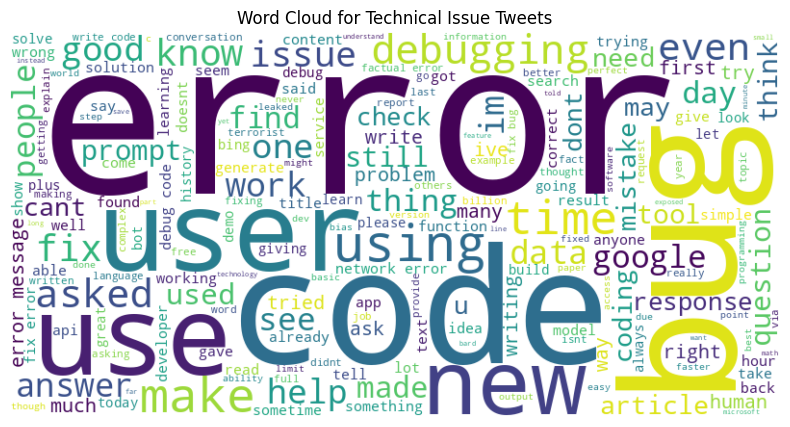

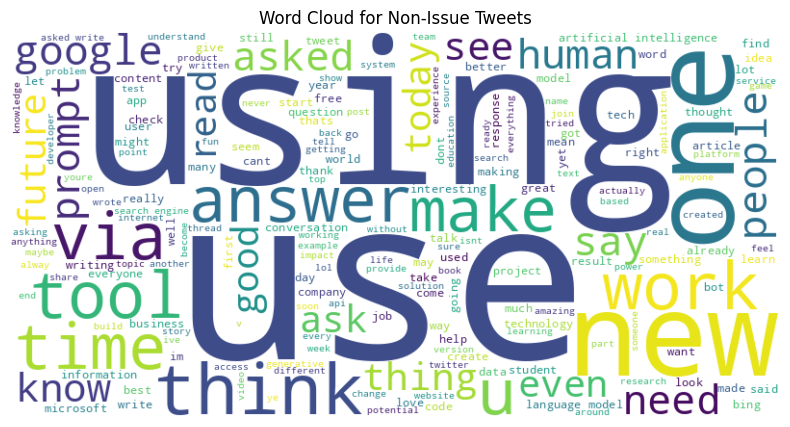

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Combine texts of each category
issue_texts = ' '.join(df[df['is_technical_issue'] == 1]['cleaned_text'])
no_issue_texts = ' '.join(df[df['is_technical_issue'] == 0]['cleaned_text'])

# Generate and display word clouds
plot_word_cloud(issue_texts, 'Word Cloud for Technical Issue Tweets')
plot_word_cloud(no_issue_texts, 'Word Cloud for Non-Issue Tweets')


## Sentiment and topic analysis

- Anticipate to see negative sentiment in technical issue tweets compared with non technical issue tweets.

- Want to try and understand main topics of technical issue tweets vs non technical issue tweets



In [8]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
import gensim

# Initialize VADER for sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def perform_analysis(tweets, title):
    # Sentiment Analysis
    tweets['sentiment'] = tweets['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

    # Tokenize texts
    tweets['tokens'] = tweets['cleaned_text'].apply(lambda x: x.split())

    # Create a dictionary and corpus for topic modeling
    dictionary = corpora.Dictionary(tweets['tokens'])
    corpus = [dictionary.doc2bow(text) for text in tweets['tokens']]

    # LDA Model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=3,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)

    # Display the topics and average sentiment
    print(f"{title} - Topics and Sentiment Analysis")
    topics = lda_model.print_topics(num_words=5)
    for topic in topics:
        print(topic)

    print("\nAverage Sentiment Score:", tweets['sentiment'].mean())
    print("---------\n")

# Separate data by label
issue_tweets = df[df['is_technical_issue'] == 1]
no_issue_tweets = df[df['is_technical_issue'] == 0]

# Analyze both sets
perform_analysis(issue_tweets, 'Technical Issue Tweets')
perform_analysis(no_issue_tweets, 'Non-Issue Tweets')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
<ipython-input-8-db3df0b98361>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sentiment'] = tweets['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
<ipython-input-8-db3df0b98361>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['tokens'] = tweets['cleaned_text'].apply(lambda x: x.split())


Technical Issue Tweets - Topics and Sentiment Analysis
(0, '0.029*"error" + 0.012*"hour" + 0.010*"bug" + 0.010*"also" + 0.009*"say"')
(1, '0.035*"error" + 0.030*"code" + 0.016*"bug" + 0.011*"write" + 0.009*"time"')
(2, '0.010*"terrorist" + 0.009*"error" + 0.008*"real" + 0.008*"since" + 0.008*"google"')

Average Sentiment Score: -0.03304936886395512
---------



<ipython-input-8-db3df0b98361>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['sentiment'] = tweets['cleaned_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
<ipython-input-8-db3df0b98361>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['tokens'] = tweets['cleaned_text'].apply(lambda x: x.split())


Non-Issue Tweets - Topics and Sentiment Analysis
(0, '0.017*"google" + 0.017*"search" + 0.015*"im" + 0.011*"u" + 0.011*"going"')
(1, '0.016*"like" + 0.014*"using" + 0.009*"get" + 0.009*"make" + 0.009*"asked"')
(2, '0.026*"use" + 0.017*"write" + 0.016*"new" + 0.015*"tool" + 0.013*"way"')

Average Sentiment Score: 0.20445424157784883
---------



Feature extraction

- Use word embeddings to try and capture nuance over traditional TDiF
- Use of all-MiniLM-L6-v2 for performance reasons.

In [33]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
# Word embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['cleaned_text'], show_progress_bar=True)



# Initialize vectorizer
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)

# Fit and transform the text data
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['is_technical_issue']


Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

Import libraries

In [41]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
import joblib

# Use SMOTE to address class imbalance

SMOTE works by creating synthetic samples rather than  duplicating existing ones. The process involves the following steps:

- Identifying the Feature Space: For each instance in the minority class, SMOTE considers its k-nearest neighbors in the feature space.
- Synthesis of New Samples: Synthetic samples are then created by choosing one of the k-nearest neighbors and drawing a line between them in the feature space. New samples are generated along this line, typically randomly placed between the two connecting samples.
- Balancing the Dataset: This process is repeated until the minority class is approximately the same size as the majority class, effectively balancing the class distribution.

- Risk of overfitting


In [35]:
# Balancing data using SMOTE
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)


embeddings_sm, y_emb_sm = smote.fit_resample(embeddings, y)

Defining models:

In [36]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(scale_pos_weight=(len(y[y == 0]) / len(y[y == 1])))
}

## Stratified K-Fold Cross-Validation Function

- Print out results of validation
- Returns an ROC plot

In [42]:

def evaluate_and_compare_models(models, X, y, n_splits=5):
    results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fig, ax = plt.subplots(figsize=(10, 5))  # Prepare figure for ROC curves

    for model_name, model in models.items():
        acc_scores = []
        precision_scores = []
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        conf_matrix_list = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_probs = model.predict_proba(X_test)[:, 1]  # probabilities
            y_pred = model.predict(X_test)

            fpr, tpr, _ = roc_curve(y_test, y_probs)
            roc_auc = auc(fpr, tpr)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            acc_scores.append(acc)
            precision_scores.append(precision)

            # Confusion matrix for this fold
            cm = confusion_matrix(y_test, y_pred)
            conf_matrix_list.append(cm)

            # Interpolate the TPR to create a smooth curve
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tprs.append(tpr_interp)

        # Average metrics over folds
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        mean_acc = np.mean(acc_scores)
        mean_precision = np.mean(precision_scores)

        # Plot ROC Curve for this model
        ax.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')

        # Save results
        results[model_name] = {
            'roc_auc': mean_auc,
            'accuracy': mean_acc,
            'precision': mean_precision,
            'confusion_matrix': np.mean(conf_matrix_list, axis=0).astype(int)
        }
        joblib.dump(model, f'{model_name}.joblib')

        # Print metrics
        print(f"\n{model_name} Results:")
        print(f"Mean ROC AUC: {mean_auc:.4f}")
        print(f"Mean Accuracy: {mean_acc:.4f}")
        print(f"Mean Precision: {mean_precision:.4f}")
        print(f"Average Confusion Matrix:\n{results[model_name]['confusion_matrix']}")

    # Complete the ROC plot
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curves')
    ax.legend(loc="lower right")
    plt.show()

    return results

Train and validate models using embeddings


Logistic Regression Results:
Mean ROC AUC: 0.9944
Mean Accuracy: 0.9847
Mean Precision: 0.9791
Average Confusion Matrix:
[[19436   419]
 [  188 19668]]

Naive Bayes Results:
Mean ROC AUC: 0.9877
Mean Accuracy: 0.9505
Mean Precision: 0.9842
Average Confusion Matrix:
[[19565   291]
 [ 1676 18180]]

XGBoost Results:
Mean ROC AUC: 0.9949
Mean Accuracy: 0.9964
Mean Precision: 0.9929
Average Confusion Matrix:
[[19713   143]
 [    0 19856]]


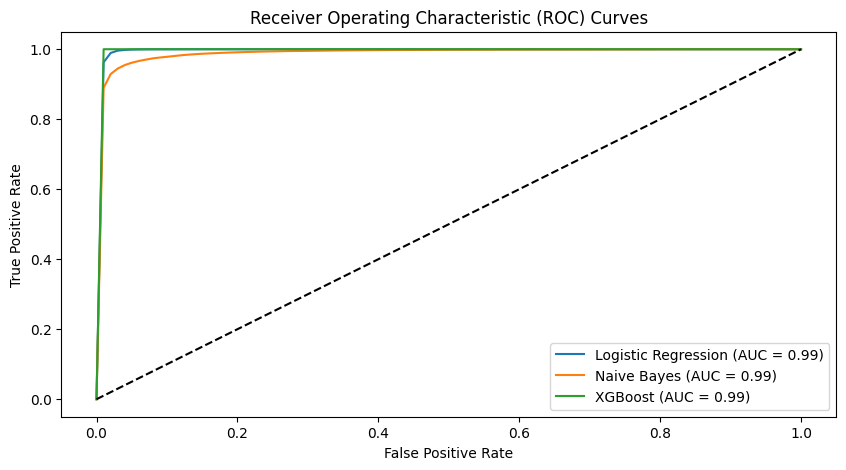

In [43]:

# Evaluate and compare models
results = evaluate_and_compare_models(models, embeddings_sm, y_emb_sm)

## Update evaluation function

Want to include confusion matricies for presentation

In [44]:

def evaluate_and_compare_models(models, X, y, n_splits=5):
    results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Prepare figure for ROC curves
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curves')

    for model_name, model in models.items():
        acc_scores = []
        precision_scores = []
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        conf_matrix_list = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_probs = model.predict_proba(X_test)[:, 1]  # probabilities
            y_pred = model.predict(X_test)

            fpr, tpr, _ = roc_curve(y_test, y_probs)
            roc_auc = auc(fpr, tpr)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            acc_scores.append(acc)
            precision_scores.append(precision)

            # Confusion matrix for this fold
            cm = confusion_matrix(y_test, y_pred)
            conf_matrix_list.append(cm)

            # Interpolate the TPR to create a smooth curve
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tprs.append(tpr_interp)

        # Average metrics over folds
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        mean_acc = np.mean(acc_scores)
        mean_precision = np.mean(precision_scores)

        # Average confusion matrix
        mean_cm = np.mean(conf_matrix_list, axis=0).astype(int)

        # Plot ROC Curve for this model
        ax.plot(mean_fpr, mean_tpr, label=f'{model_name} (AUC = {mean_auc:.2f})')

        # Display the average confusion matrix
        fig_cm, ax_cm = plt.subplots()
        disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=["Non-Issue", "Issue"])
        disp.plot(ax=ax_cm, cmap='Blues', values_format='d')
        ax_cm.set_title(f'Average Confusion Matrix for {model_name}')
        plt.show()

        # Save results
        results[model_name] = {
            'roc_auc': mean_auc,
            'accuracy': mean_acc,
            'precision': mean_precision,
            'confusion_matrix': mean_cm
        }
        joblib.dump(model, f'{model_name}.joblib')

        print(f"\n{model_name} Results:")
        print(f"Mean ROC AUC: {mean_auc:.4f}")
        print(f"Mean Accuracy: {mean_acc:.4f}")
        print(f"Mean Precision: {mean_precision:.4f}")
        print(f"Average Confusion Matrix:\n{mean_cm}")

    ax.legend(loc="lower right")
    plt.show()

    return results

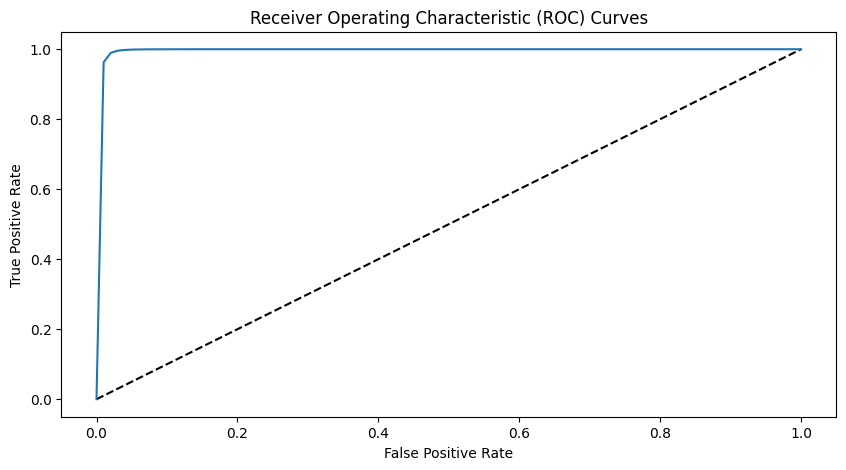

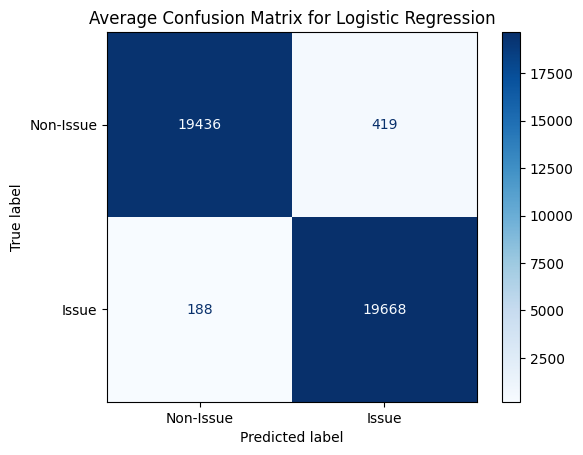


Logistic Regression Results:
Mean ROC AUC: 0.9944
Mean Accuracy: 0.9847
Mean Precision: 0.9791
Average Confusion Matrix:
[[19436   419]
 [  188 19668]]


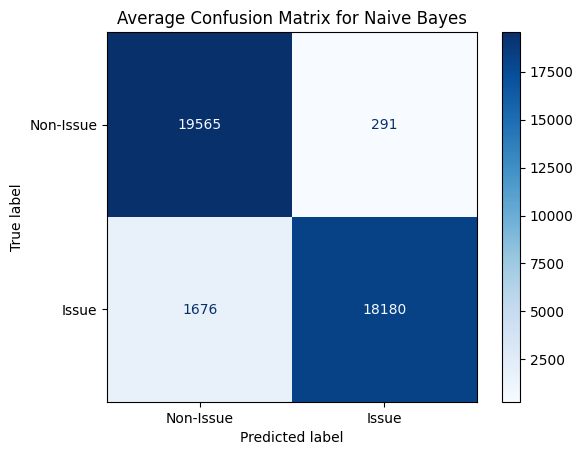


Naive Bayes Results:
Mean ROC AUC: 0.9877
Mean Accuracy: 0.9505
Mean Precision: 0.9842
Average Confusion Matrix:
[[19565   291]
 [ 1676 18180]]


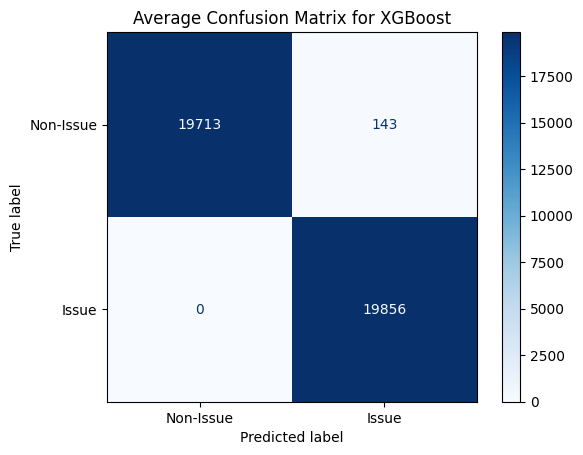


XGBoost Results:
Mean ROC AUC: 0.9949
Mean Accuracy: 0.9964
Mean Precision: 0.9929
Average Confusion Matrix:
[[19713   143]
 [    0 19856]]


In [45]:

# Evaluate and compare models
results = evaluate_and_compare_models(models, embeddings_sm, y_emb_sm)